In [13]:
from src.dataset import make_corewise_bk_dataloaders

train, val, test = make_corewise_bk_dataloaders(
    batch_sz=1, style='last_frame'
)

Train: 1553
Val: 343
Test: 335
center
QUEENS    932
UBC       621
Name: count, dtype: int64
Found 1553 files.
Found 343 files.
Found 334 files.


In [14]:
import pandas as pd

table_train = train.dataset.table
table_val = val.dataset.table
table_test = test.dataset.table

table_train['split'] = 'train'
table_val['split'] = 'val'
table_test['split'] = 'test'

table = pd.concat([table_train, table_val, table_test])

In [15]:
train_ids = table_train.patient_id.unique()
val_ids = table_val.patient_id.unique()
test_ids = table_test.patient_id.unique()

assert set(train_ids).isdisjoint(val_ids)
assert set(train_ids).isdisjoint(test_ids)
assert set(val_ids).isdisjoint(test_ids)


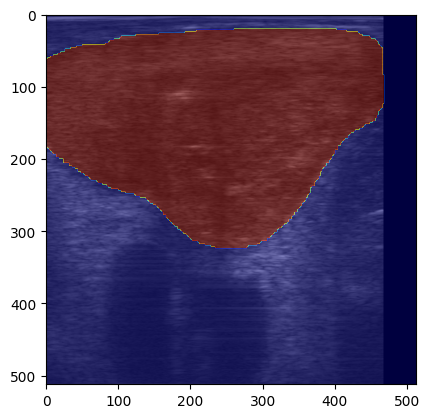

In [16]:
img, needle_mask, prostate_mask, label, inv, core_id, patient_id = train.dataset[0]
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray', extent=(0, 512, 512, 0))
plt.imshow(prostate_mask, cmap='jet', alpha=0.5, extent=(0, 512, 512, 0))

import torch 
img = (img - img.min() ) / (img.max() - img.min())
img = torch.tensor(img).unsqueeze(0).unsqueeze(0)
from torchvision.transforms import Resize
img = torch.cat([img, img, img], dim=1)
img = Resize((256, 256))(img)

In [20]:
batch = next(iter(train))

def prepare_batch(batch, device): 
    img, needle, prostate, label, inv, core_id, patient_id = batch
    img = (img - img.min() ) / (img.max() - img.min())
    # from torchvision.transforms import Resize
    # img = Resize((img_size, img_size))(img)
    img = img.unsqueeze(1)
    img = torch.cat([img, img, img], dim=1)

    needle = needle.unsqueeze(0)
    prostate = prostate.unsqueeze(0)

    return img.to(device), needle.to(device), prostate.to(device), label.to(device), core_id

img, needle_mask, prostate_mask, label, core_id = prepare_batch(batch, 'cuda')


In [21]:
print(img.shape)

torch.Size([1, 3, 1024, 1024])


In [22]:
model(img)

tensor([[[[-14.1220, -15.2106, -13.7319,  ..., -15.7262, -13.7116, -13.1073],
          [-14.9204, -15.5084, -15.6609,  ..., -16.1237, -15.2980, -12.7311],
          [-15.4328, -18.7447, -19.4912,  ..., -19.4413, -18.4251, -15.3547],
          ...,
          [-15.4687, -15.1035, -15.7179,  ..., -16.7062, -15.1618, -12.7945],
          [-15.6667, -17.5961, -18.3005,  ..., -19.3601, -18.5743, -15.9836],
          [-14.2305, -15.0459, -17.7439,  ..., -16.2497, -18.7044, -14.0045]]]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [23]:
from src.sam_wrappers import build_medsam
sam_backbone = build_medsam()
from src.prostnfound import ProstNFound 

model = ProstNFound(
    sam_backbone, 
    auto_resize_image_to_native=False
).to('cuda')

from src.loss import CancerDetectionValidRegionLoss, MaskedPredictionModule
loss_fn = CancerDetectionValidRegionLoss(    
    loss_pos_weight=2.0,
)

In [24]:
LR = 1e-5
WARMUP_EPOCHS = 5
EPOCHS = 30
ACCUMULATE_GRAD_STEPS = 8
DEV_MODE = False

from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, ChainedScheduler
opt = Adam(model.parameters(), lr=LR)
n_iters_per_epoch = len(train)
scheduler = ChainedScheduler([
    LinearLR(opt, 0.00001, 1, total_iters=WARMUP_EPOCHS * n_iters_per_epoch),
    CosineAnnealingLR(opt, (EPOCHS) * n_iters_per_epoch),
])



if DEV_MODE: 
    lrs = [] 
    for iter_ in range(EPOCHS * n_iters_per_epoch):
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
    plt.plot(lrs)

In [39]:
import torch.amp
from src.utils import calculate_metrics
import numpy as np
from tqdm import tqdm 

class Tracker: 
    def __init__(self): 
        self.core_ids = []
        self.mean_predictions_in_needle = []

    def update(self, core_ids, mean_predictions_in_needle): 
        self.core_ids.extend(core_ids)
        self.mean_predictions_in_needle.append(mean_predictions_in_needle.detach().cpu())

    def get(self): 
        return self.core_ids, torch.cat(self.mean_predictions_in_needle)

    def compute_metrics(self, core_id_to_metadata_dict, log_images=False): 
        core_ids, mean_predictions_in_needle = self.get()        

        labels = [] 
        preds = []
        involvement = []
        for core_id, prediction in zip(core_ids, mean_predictions_in_needle): 
            label = core_id_to_metadata_dict[core_id]['label']
            labels.append(label)
            involvement.append(core_id_to_metadata_dict[core_id]['inv'])
            preds.append(prediction.item())

        labels = np.array(labels)
        preds = np.array(preds)
        involvement = np.array(involvement)
        
        metrics_all = calculate_metrics(preds, labels, log_images=log_images)

        high_inv_mask = (involvement > 0.4) | (labels == 0)
        metrics_high_inv = calculate_metrics(preds[high_inv_mask], labels[high_inv_mask], log_images=log_images)

        metrics = {}
        metrics.update(metrics_all)
        metrics.update({f'{k}_high_inv': v for k, v in metrics_high_inv.items()})

        return metrics


def train_epoch(loader, model, loss_fn, opt, scheduler, scaler=None, device='cuda', accumulate_grad_steps=1, log_fn=None):
    tracker = Tracker()
    for i, batch in enumerate(tqdm(loader)): 
        img, needle_mask, prostate_mask, label, core_ids = prepare_batch(batch, device)

        # forward pass
        with torch.amp.autocast_mode.autocast(
            device, enabled=scaler is not None
        ): 
            logits = model(img)
            loss = loss_fn(logits, prostate_mask, needle_mask, label, None)
            loss /= accumulate_grad_steps
        
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        if (i + 1) % accumulate_grad_steps == 0:
            if scaler is not None:
                scaler.step(opt)
                scaler.update()
            else: 
                opt.step()
                opt.zero_grad()
        
        scheduler.step()
        
        if log_fn is not None: 
            log_fn(
                {
                    'loss': loss.item(),
                    'lr': scheduler.get_last_lr()[0]
                }
            )

        # compute predictions
        masks = (prostate_mask > 0.5) & (needle_mask > 0.5)
        predictions, batch_idx = MaskedPredictionModule()(logits, masks)
        mean_predictions_in_needle = []
        B = img.shape[0]
        for j in range(B):
            mean_predictions_in_needle.append(
                predictions[batch_idx == j].sigmoid().mean()
            )
        mean_predictions_in_needle = torch.stack(mean_predictions_in_needle) 

        # update tracker
        tracker.update(core_ids, mean_predictions_in_needle)
        
    table = loader.dataset.table.copy()
    table.set_index('core_id', inplace=True)
    d = table.to_dict(orient='index')
    metrics = tracker.compute_metrics(d, log_images=True)

    return metrics


@torch.no_grad()
def validation_epoch(loader, model, loss_fn, device, use_amp=False, log_fn=None):
    tracker = Tracker()
    for i, batch in enumerate(tqdm(loader)): 
        img, needle_mask, prostate_mask, label, core_ids = prepare_batch(batch, device)

        # forward pass
        with torch.amp.autocast_mode.autocast(
            device, enabled=use_amp
        ): 
            logits = model(img)
            loss = loss_fn(logits, prostate_mask, needle_mask, label, None)

        if log_fn is not None: 
            log_fn({'loss': loss.item()})

        # compute predictions
        masks = (prostate_mask > 0.5) & (needle_mask > 0.5)
        predictions, batch_idx = MaskedPredictionModule()(logits, masks)
        mean_predictions_in_needle = []
        B = img.shape[0]
        for j in range(B):
            mean_predictions_in_needle.append(
                predictions[batch_idx == j].sigmoid().mean()
            )
        mean_predictions_in_needle = torch.stack(mean_predictions_in_needle) 

        # update tracker
        tracker.update(core_ids, mean_predictions_in_needle)
        
    table = loader.dataset.table.copy()
    table.set_index('core_id', inplace=True)
    d = table.to_dict(orient='index')
    metrics = tracker.compute_metrics(d, log_images=True)

    return metrics

train_epoch(train, model, loss_fn, opt, scheduler)    

  0%|          | 0/1553 [00:00<?, ?it/s]

  1%|          | 11/1553 [00:09<22:08,  1.16it/s]
/fs01/home/pwilson/projects/prostNfoundBK/src/utils.py:100: UserWarning: ROC AUC score could not be calculated. Setting to 0.5
  warnings.warn("ROC AUC score could not be calculated. Setting to 0.5")
/fs01/home/pwilson/.conda/envs/medibot/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/fs01/home/pwilson/.conda/envs/medibot/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/fs01/home/pwilson/.conda/envs/medibot/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/fs01/ho

{'auc': 0.5,
 'sens_at_20_spe': nan,
 'sens_at_40_spe': nan,
 'sens_at_60_spe': nan,
 'sens_at_80_spe': nan,
 'f1': 0.0,
 'histogram': <wandb.sdk.data_types.image.Image at 0x7fe7bc56e420>,
 'roc_curve': <wandb.sdk.data_types.image.Image at 0x7fe7bded4a70>,
 'auc_high_inv': 0.5,
 'sens_at_20_spe_high_inv': nan,
 'sens_at_40_spe_high_inv': nan,
 'sens_at_60_spe_high_inv': nan,
 'sens_at_80_spe_high_inv': nan,
 'f1_high_inv': 0.0,
 'histogram_high_inv': <wandb.sdk.data_types.image.Image at 0x7fe7bc212330>,
 'roc_curve_high_inv': <wandb.sdk.data_types.image.Image at 0x7fe7bc1636e0>}

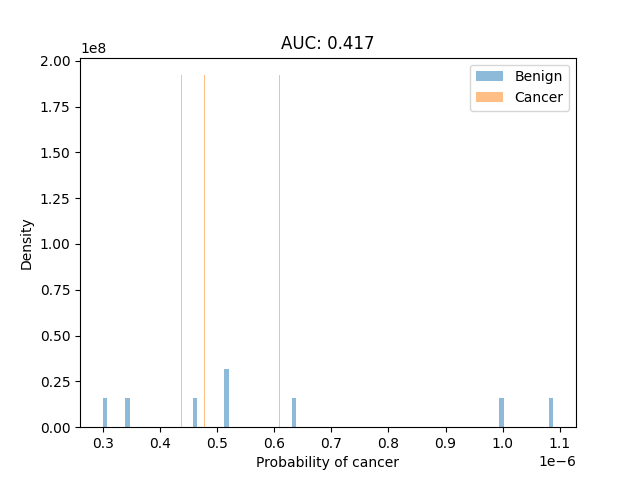

In [38]:
metrics['histogram'].image


In [43]:

from argparse import ArgumentParser
from src.slurm import add_submitit_args

parser = ArgumentParser()
#parser.add_argument('--exp_dir', type=str, default='.')
add_submitit_args(parser)

In [44]:
parser.print_help()

usage: ipykernel_launcher.py [-h] --exp_dir EXP_DIR

options:
  -h, --help         show this help message and exit
  --exp_dir EXP_DIR  Experiment directory.
